In [1]:
import numpy as np
from scipy.stats import norm
from scipy.special import comb
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from time import time

In [2]:
"""array1 = np.array([0])
np.append(array1,12)"""

'array1 = np.array([0])\nnp.append(array1,12)'

In [3]:
def bs(S, K, T, r, dr, sigma, option):
    
    d1 = (np.log(S / (K * np.exp(-(r - dr) * T))) / (sigma * np.sqrt(T))) + 0.5 * sigma * np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2) 
    
    if option == "call":
        price = S * np.exp(-dr * T) * Nd1 - K * np.exp(-r * T) * Nd2
    elif option == "put":
        price = -S * np.exp(-dr * T) * (1 - Nd1) + K * np.exp(-r * T) * (1 - Nd2)
        
    return price

In [4]:
def bin_comb(S, K, T, r, dr,sigma, N, option): # binomial tree with combinatorics

    delta_T = T / N  # Each time step
    u = np.exp(sigma * np.sqrt(delta_T))  # Proportion of upward movement
    d = 1 / u  # Proportion of downward movement
    q = (np.exp((r - dr) * delta_T) - d) / (u - d)  # Probability of upward movement
    prob_vec = np.array([q**i * (1 - q)**(N - i) * comb(N, i) for i in range(N + 1)])
    
    bound = int((np.log(K / S) - N * np.log(d)) / np.log(u / d)) + 1  # the critical value 
    if option == "call":
        final_payoff = np.array([S * u**i * d**(N - i) - K for i in range(bound, N + 1)])
        prob_vec = prob_vec[bound:]  # Binomial distribution
        
    elif option == "put":
        final_payoff = np.array([K - S * u**i * d**(N - i)  for i in range(bound)])
        prob_vec = prob_vec[:bound]  # Binomial distribution
        
    # Calculating the final payoff
    expected_final_payoff = final_payoff * prob_vec
    final_chosen_df = np.exp(-r * T) * expected_final_payoff
    price = sum(final_chosen_df)
    
    return price

In [5]:
def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def binomial_tree(S, K, T, r, dr,sigma, N, option, A = False):  # general binomial tree
    delta_T = T / N  # Each time step
    u = np.exp(sigma * np.sqrt(delta_T))  # Proportion of upward movement
    d = 1 / u  # Proportion of downward movement
    q = (np.exp((r - dr) * delta_T) - d) / (u - d)  # Probability of upward movement
    path = np.zeros([N+1,N+1])

    for i in range(N+1):
        for j in range(i+1):
            path[i,j] = S * u**(i-j) * d**(j)
            
    if option == "call":
        path = np.maximum(path - K,0)
    elif option == "put":
        path = np.maximum(-path + K,0)
        
    payoff = path[N]
    
    for i in range(N,0,-1):
        payoff = (payoff[:-1] * q + payoff[1:] * (1 - q))* np.exp(-r*delta_T)
        if A == True:
            payoff = np.maximum(path[i-1][:len(payoff)],payoff)
        
    return payoff[0]

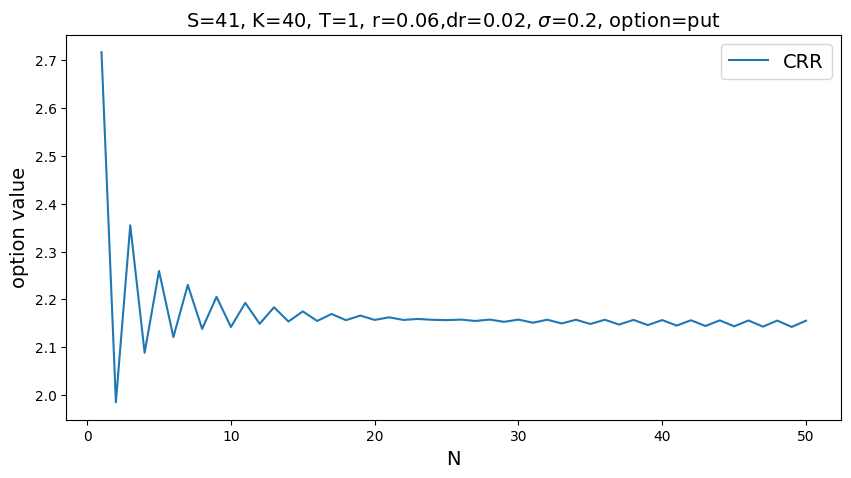

In [6]:
S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
option = 'put'
N = np.arange(1, 51)
crr_res = []
for n in N:
    crr_res.append(binomial_tree(S, K, T, r,dr,sigma, n, option, True))

plt.figure(figsize=(10,5))
plt.plot(N, crr_res, label='CRR')
plt.title(f'S={S}, K={K}, T={T}, r={r},dr={dr}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [7]:
def stock_simu(S, T, r, dr, sigma, N, M, seed):
    dt = T / N
    np.random.seed(seed)  
    paths = np.zeros((N + 1, M))
    paths[0] = S

    for t in range(1, N + 1):
        Z = np.random.standard_normal(int(M/2))
        Z = np.concatenate((Z, -Z))
        paths[t] = paths[t - 1] * np.exp(((r -dr) - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def least_squares_MC(S, K, T, r, dr,sigma, M, N, order, option='put',model = "lsmc", alpha = 0.1, bandwidth=0.3,seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, dr,sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        
        if model == "lsmc":
            reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
            C = np.polyval(reg, stock_paths[t][in_the_money])
            
        elif model == "ridge":
            model = Ridge(alpha=alpha, fit_intercept=True)
            X = stock_paths[t][in_the_money].reshape(-1, 1)
            Y = (exercise_values[t + 1] * df)[in_the_money]
            model.fit(X, Y)
            C = model.predict(X)
            
        elif model == "nonparametric":
            X = stock_paths[t][in_the_money]
            Y = (exercise_values[t + 1] * df)[in_the_money]
            lowess = sm.nonparametric.lowess(Y, X, frac=bandwidth)
            
            # Extracting the smoothed values
            C = lowess[:, 1][np.argsort(lowess[:, 0])]

            sorted_indices = np.argsort(X)
            
            C = C[sorted_indices]
            
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def least_squares_MC(S, K, T, r, dr,sigma, M, N, order, option='put',model = "lsmc", alpha = 0.1, bandwidth=0.3,seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N))
    stock_paths = stock_simu(S, T, r, dr,sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        
        if model == "lsmc":
            reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
            C = np.polyval(reg, stock_paths[t][in_the_money])
            
        elif model == "ridge":
            
            # Define polynomial features (if needed)
            poly_degree = 5 # You can adjust the degree
            ridge_model = make_pipeline(PolynomialFeatures(poly_degree), Ridge(alpha=alpha,normalize=True))
            
            # Reshape data for the model
            X = stock_paths[t][in_the_money].reshape(-1, 1)
            Y = (exercise_values[t + 1] * df)[in_the_money]
            # Fit the model
            ridge_model.fit(X, Y)
            
            
            # Predict the continuation values
            C = ridge_model.predict(X)
            
        elif model == "nonparametric":
            X = stock_paths[t][in_the_money]
            Y = (exercise_values[t + 1] * df)[in_the_money]
            lowess = sm.nonparametric.lowess(Y, X, frac=bandwidth)
            
            # Extracting the smoothed values
            C = lowess[:, 1][np.argsort(lowess[:, 0])]

            sorted_indices = np.argsort(X)
            
            C = C[sorted_indices]
            
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5

In [9]:
def _Kc(K, T, r, dr, sigma):
    
    _ITERATION_MAX_ERROR = 0.00001
    N1 = 2 * (r - dr) / sigma**2
    M1 = 2 * r / sigma**2
    q2u = (-1 * (N1 - 1) + ((N1 - 1)**2 + 4 * M1)**0.5) / 2  # p27.
    su = K / (1 - 1 / q2u)                                # p27.
    h2 = -1 * ((r - dr) * T + 2 * sigma * np.sqrt(T)) * K / (su - K)  # p31.
    Si = K + (su - K) * (1 - np.exp(h2))                       # p31.

    K1 = (1 - np.exp(-1 * r * T))
    d1 = (np.log(Si / K) + ((r - dr) + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    q2 = (-1 * (N1 - 1) + ((N1 - 1)**2 + 4 * M1 / K1)**0.5) / 2  # p16.
    LHS = Si - K
    RHS = bs(Si, K, T, r, dr, sigma,"call") + (1 - np.exp(- dr * T) * norm.cdf(d1,0.0,1.0)) * Si / q2  # p23.
    bi = np.exp(-dr * T) * norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp(-dr * T) * norm.pdf(d1,0.0,1.0) / (sigma * np.sqrt(T))) / q2  # p25. 

    E = _ITERATION_MAX_ERROR
    
    while np.abs(LHS - RHS) / K > E:        # p26.
        Si = (K + RHS - bi * Si) / (1 - bi) # p25.
        d1 = (np.log(Si / K) + ((r - dr) + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        LHS = Si - K
        RHS = bs(Si, K, T, r, dr, sigma,"call") + (1 - np.exp(- dr * T) * norm.cdf(d1,0.0,1.0)) * Si / q2
        bi = np.exp(-dr * T) * norm.cdf(d1,0.0,1.0) * (1 - 1 / q2) + (1 - np.exp(-dr * T) * norm.pdf(d1,0.0,1.0) / (sigma * np.sqrt(T))) / q2
    
    return Si

In [10]:
def _Kp(K, T, r, dr, sigma):
    
    _ITERATION_MAX_ERROR = 0.00001
    N1 = 2 * (r - dr) / sigma**2
    M1 = 2 * r / sigma**2
    q1u = (-1 * (N1 - 1) - ((N1 - 1)**2 + 4 * M1)**0.5) / 2
    su = K / (1 - 1 / q1u)
    h1 = ((r-dr) * T - 2 * sigma * (T)**0.5) * K / (K - su)
    Si = su + (K - su) * np.exp(h1)

    k = 2 * r / (sigma**2 * (1 - np.exp(-1 * r * T)))
    d1 = (np.log(Si / K) + ((r-dr) + sigma**2 / 2) * T) / (sigma * (T)**0.5)
    Q1 = (-1 * (N1 - 1) - ((N1 - 1)**2 + 4 * k)**0.5) / 2
    LHS = K - Si
    RHS = bs(Si, K, T, r, dr, sigma,"put") - (1 - np.exp(-dr * T) * norm.cdf(-d1,0.0,1.0)) * Si / Q1
    bi = -1 * np.exp(-dr * T) * norm.cdf(-d1,0.0,1.0) * (1 - 1 / Q1) - (1 + np.exp(-dr * T) * norm.pdf(-d1,0.0,1.0) / (sigma * (T)**0.5)) / Q1
    
    E = _ITERATION_MAX_ERROR
    
    while np.abs(LHS - RHS) / K > E:
        Si = (K - RHS + bi * Si) / (1 + bi)
        d1 = (np.log(Si / K) + ((r-dr) + sigma**2 / 2) * T) / (sigma * (T)**0.5)
        LHS = K - Si
        RHS = bs(Si, K, T, r, dr, sigma,"put") - (1 - np.exp(-dr * T) * norm.cdf(-d1,0.0,1.0)) * Si / Q1
        bi = -np.exp(-dr * T) * norm.cdf(-d1,0.0,1.0) * (1 - 1 / Q1) - (1 + np.exp(-dr * T) * norm.pdf(-d1,0.0,1.0) / (sigma * (T)**0.5)) / Q1
        
    return Si

In [11]:
def bawCall(S, K, T, r, dr, sigma):
    '''
    Barone-Adesi And Whaley
    '''

    if (r - dr) >= r:                               # 無股利發放
        return bs(S, K, T, r, dr, sigma,"call")
    else:                                    # 有股利發放
        Sk = _Kc(K, T, r, dr, sigma)
        N1 = 2 * (r - dr) /sigma**2
        M1 = 2 * r / sigma**2
        K1 = (1 - np.exp(-1 * r * T))
        d1 = (np.log(Sk / K) + ((r-dr) + (sigma**2) / 2) * T) / (sigma * (T**0.5))
        q2 = (-1 * (N1 - 1) + ((N1 - 1)**2 + 4 * M1 / K1))**0.5 / 2
        a2 = (Sk / q2) * (1 - np.exp(-dr * T) * norm.cdf(d1,0.0,1.0))  # P21.
        if S < Sk:
            return bs(S, K, T, r, dr, sigma,"call") + a2 * (S / Sk)**q2  # 小於臨界股價 P21.
        else:
            return S - K                  

In [12]:
def bawput(S, K, T, r, dr, sigma):
    '''
    Barone-Adesi-Whaley
    '''

    Sk = _Kp(K, T, r, dr, sigma)
    N1 = 2 * (r-dr) / sigma**2
    k = 2 * r / (sigma**2 * (1 - np.exp(-1 * r * T)))
    d1 = (np.log(Sk / K) + ((r-dr) + (sigma**2) / 2) * T) / (sigma * (T)**0.5)
    Q1 = (-1 * (N1 - 1) - (((N1 - 1)**2 + 4 * k))**0.5) / 2
    a1 = -1 * (Sk / Q1) * (1 - np.exp(-dr * T) * norm.cdf(-d1,0.0,1.0))

    if S > Sk:
        return bs(S, K, T, r, dr, sigma,"put") + a1 * (S / Sk)**Q1
    else:
        return K - S

In [13]:
def baw(S, K, T, r, dr, sigma,option = "put"):
    
    if option == "put":
        return bawput(S, K, T, r, dr, sigma)
    
    elif option == "call":
        return bawCall(S, K, T, r, dr, sigma)
    

In [14]:
def americanopt(S, K, T, r, dr, sigma,num_rep,num_step,option = "put"):
    
    baw_value = baw(S, K, T, r, dr, sigma,option)
    binomial_tree_value = binomial_tree(S, K, T, r,dr,sigma, 100, option, True)
    lsmc_mean,lsmc_std = least_squares_MC(S, K, T, r, dr,sigma, num_rep, num_step, 5, option,model = "lsmc", alpha = 0.1, bandwidth=0.3,seed=123)
    lsmc_ci = np.array([lsmc_mean-1.96*lsmc_std,lsmc_mean+1.96*lsmc_std])
    print("baw value is {}".format(baw_value))
    print("binomial tree value is {}".format(binomial_tree_value))
    print("LSMC value is {}".format(lsmc_mean))
    print("LSMC CI is {}".format(lsmc_ci))
    
    return baw_value,binomial_tree_value,lsmc_mean,lsmc_ci

In [15]:
"""S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
N = 50"""

S = float(input("stock price"))
K = float(input("strike price"))
T = float(input("time to maturity"))
r = float(input("rf rate"))
dr = float(input("dividend ratio"))
sigma = float(input("volatility"))
number_rep = int(input("number of rep"))
num_step = int(input("number of steps"))
option = input("call or put")

stock price41
strike price40
time to maturity1
rf rate0.06
dividend ratio0.02
volatility0.2
number of rep20
number of steps50
call or putput


In [16]:
americanopt(S, K, T, r, dr, sigma,number_rep,num_step,option)

baw value is 2.1553346522929893
binomial tree value is 2.149954663360156
LSMC value is 3.1194856704933356
LSMC CI is [1.8002888  4.43868254]


(2.1553346522929893,
 2.149954663360156,
 3.1194856704933356,
 array([1.8002888 , 4.43868254]))

In [17]:
americanopt(S, K, T, r, dr, sigma,number_rep,num_step,option = "call")

baw value is 4.520007196331216
binomial tree value is 4.526309039402526
LSMC value is 6.297281758617825
LSMC CI is [4.15412684 8.44043667]


(4.520007196331216,
 4.526309039402526,
 6.297281758617825,
 array([4.15412684, 8.44043667]))

In [18]:
americanopt(S, K, T, r, dr, sigma,10000,num_step,option)

baw value is 2.1553346522929893
binomial tree value is 2.149954663360156
LSMC value is 2.0649508597170145
LSMC CI is [2.01352226 2.11637946]


(2.1553346522929893,
 2.149954663360156,
 2.0649508597170145,
 array([2.01352226, 2.11637946]))

In [19]:
americanopt(S, K, T, r, dr, sigma,10000,num_step,option = "call")

baw value is 4.520007196331216
binomial tree value is 4.526309039402526
LSMC value is 4.389071879233246
LSMC CI is [4.28020802 4.49793574]


(4.520007196331216,
 4.526309039402526,
 4.389071879233246,
 array([4.28020802, 4.49793574]))

In [20]:
americanopt(S, K, 5, r, dr, sigma,10000,50,option = "put")

baw value is 3.9556830914537198
binomial tree value is 3.866273504883028
LSMC value is 3.7193018154094766
LSMC CI is [3.637851   3.80075263]


(3.9556830914537198,
 3.866273504883028,
 3.7193018154094766,
 array([3.637851  , 3.80075263]))

In [21]:
americanopt(S, K, 5, r, dr, sigma,10000,50,option = "call")

baw value is 10.390758240923224
binomial tree value is 10.358501946549799
LSMC value is 10.098024362921116
LSMC CI is [ 9.82524532 10.37080341]


(10.390758240923224,
 10.358501946549799,
 10.098024362921116,
 array([ 9.82524532, 10.37080341]))

In [22]:
americanopt(S, K, 60, r, dr, sigma,10000,50,option = "put")

baw value is 4.989186286946481
binomial tree value is 4.82432366074771
LSMC value is 4.569981569176559
LSMC CI is [4.47342527 4.66653787]


(4.989186286946481,
 4.82432366074771,
 4.569981569176559,
 array([4.47342527, 4.66653787]))

In [23]:
americanopt(S, K, 60, r, dr, sigma,10000,50,option = "call")

baw value is 15.849784212435203
binomial tree value is 20.159514176785713
LSMC value is 19.725346239144496
LSMC CI is [19.24074812 20.20994436]


(15.849784212435203,
 20.159514176785713,
 19.725346239144496,
 array([19.24074812, 20.20994436]))

# LSMC comparison

### Put

Pricing Value
-----------------
Monte Carlo mean: 2.065
Monte Carlo std: 0.026


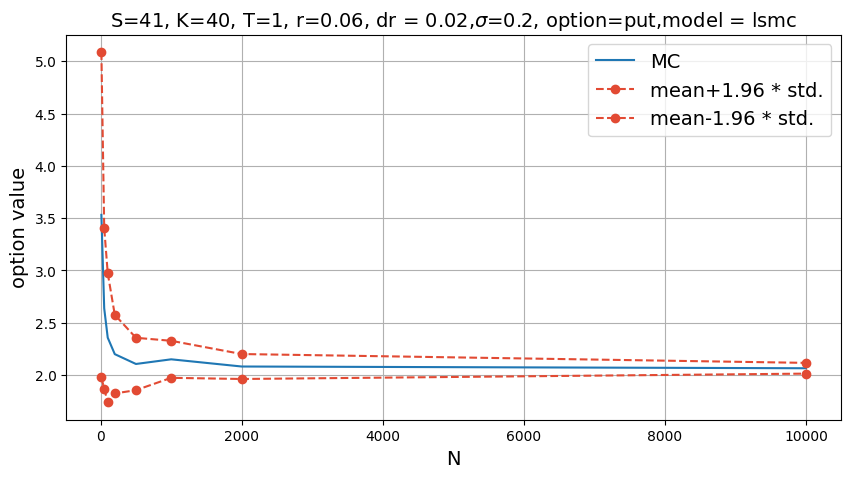

In [24]:
S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'put'
M = [10, 50, 100, 200, 500, 1000, 2000, 10000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r,dr, sigma, n, N, 5,option, model="lsmc")
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, dr = {dr},$\sigma$={sigma}, option={option},model = {"lsmc"}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Pricing Value
-----------------
Monte Carlo mean: 1.893
Monte Carlo std: 0.021


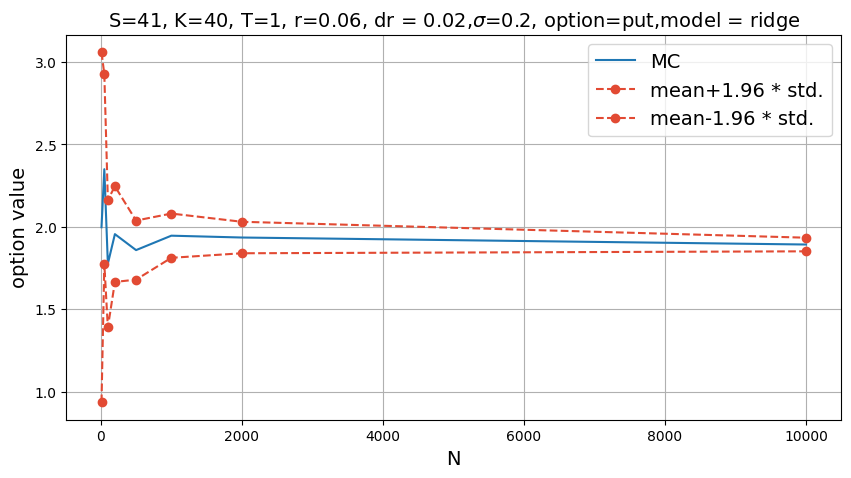

In [25]:
S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'put'
M = [10, 50, 100, 200, 500, 1000, 2000, 10000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r,dr, sigma, n, N, 5,option,model="ridge")
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, dr = {dr},$\sigma$={sigma}, option={option},model = {"ridge"}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Call

Pricing Value
-----------------
Monte Carlo mean: 4.389
Monte Carlo std: 0.056


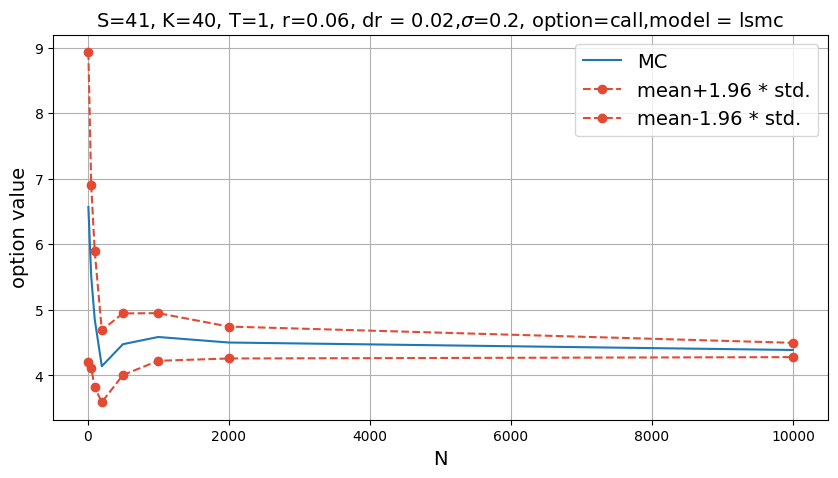

In [26]:
S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'call'
M = [10, 50, 100, 200, 500, 1000, 2000, 10000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r,dr, sigma, n, N, 5,option, model="lsmc")
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, dr = {dr},$\sigma$={sigma}, option={option},model = {"lsmc"}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Pricing Value
-----------------
Monte Carlo mean: 4.089
Monte Carlo std: 0.041


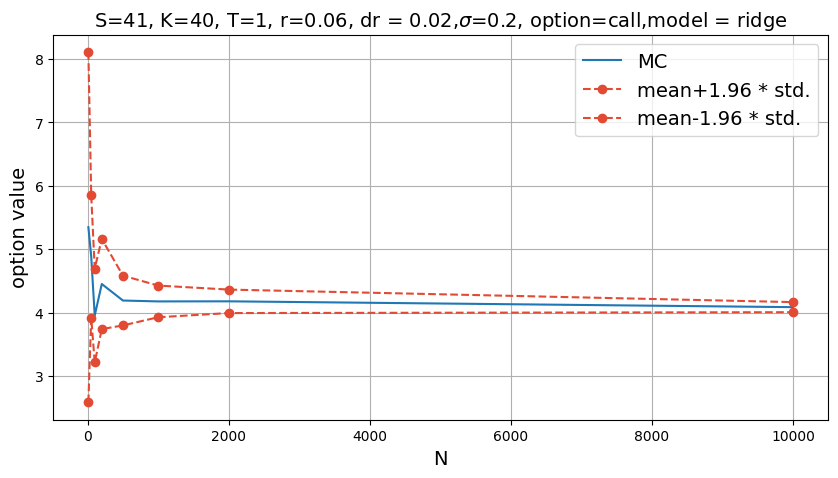

In [27]:
S = 41
K = 40
T = 1
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'call'
M = [10, 50, 100, 200, 500, 1000, 2000, 10000]
mc_mean = []
mc_std = []
for n in M:
    m, s = least_squares_MC(S, K, T, r,dr, sigma, n, N, 5,option,model="ridge")
    mc_mean.append(m)
    mc_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)

analysis_N = M
print('=================')
print('Pricing Value')
print('-----------------')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')

plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.grid()

plt.title(f'S={S}, K={K}, T={T}, r={r}, dr = {dr},$\sigma$={sigma}, option={option},model = {"ridge"}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Different time length

In [28]:
# Put
S = 41
K = 40
T = 5
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'put'
ls = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="lsmc")
ridg = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="ridge")
ls,ridg

((3.7193018154094766, 0.04155653868007653),
 (3.524624984072923, 0.03585902169677152))

In [29]:
# Call
S = 41
K = 40
T = 5
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'call'
ls = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="lsmc")
ridg = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="ridge")
ls,ridg

((10.098024362921116, 0.1391729836020767),
 (9.326351369066316, 0.0948601599020857))

In [30]:
# Put
S = 41
K = 40
T = 10
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'put'
ls = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="lsmc")
ridg = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="ridge")
ls,ridg

((4.2663928896189525, 0.04604689593519752),
 (4.106174614005431, 0.04036476343214846))

In [31]:
# Call
S = 41
K = 40
T = 10
r = 0.06
dr = 0.02
sigma = 0.2
N = 50
option = 'call'
ls = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="lsmc")
ridg = least_squares_MC(S, K, T, r,dr, sigma, 10000, 50, 5, option, model="ridge")
ls,ridg

((13.784302153234929, 0.17743387495169385),
 (13.05908250260795, 0.13303703018389637))

## Implied Volatility

In [32]:
def newton_method(S, K, T, r, dr, mkt_price,option):
    sigma = np.sqrt(abs(np.log(S/(K*np.exp(-r*T))))*2/T)
    bs_price = bs(S, K, T, r, dr, sigma, option)

    while abs(bs_price - mkt_price) > 10**(-4):
        d1 = np.log(S/(K*np.exp(-r*T)))/(sigma*np.sqrt(T)) + 0.5*sigma*np.sqrt(T)
        sigma = sigma - (bs_price - mkt_price)/(S*np.exp(-dr*T)*np.sqrt(T)*norm.pdf(d1,0,1))
        bs_price = bs(S, K, T, r, dr, sigma, option)

        
    return sigma  

In [33]:
def bisection(S, K, T, r, dr, mkt_price,option):
    a = 10**(-3)
    b = 0.8
    x = 0.5 * (a + b)
    def f(y):
        sign = np.sign(bs(S, K, T, r, dr, y, option) - mkt_price)
        return sign
    sigma_list = []
    sigma_list.append(x)    
    while abs(bs(S, K, T, r, dr, x, option) - mkt_price) > 10**(-4):
        if f(a) == f(x):
            a = x
        elif f(b) == f(x):
            b = x
        x = 0.5*(a+b) 
        sigma_list.append(x)
        
        
    print(len(sigma_list))
    
    return x  

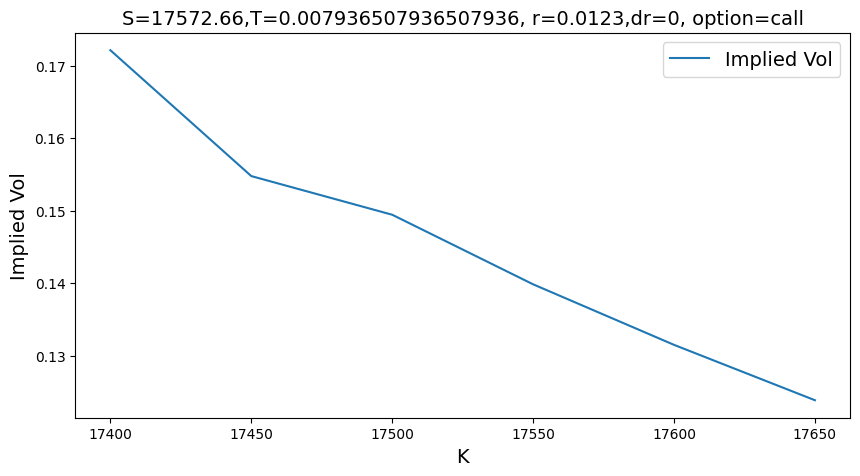

[0.17213290735660916, 0.15476634839828085, 0.14943396934147052, 0.1398358161598388, 0.13148289791281095, 0.12384299786530538]


In [34]:
# 2024/1/8 TXO price
K = [17400,17450,17500,17550,17600,17650]
c = [216,171,135,100,70,45.5]
p = [11.5,18.5,28,43,63,90]
S = 17572.66
T = 2/252
r = 0.0123
dr = 0

impvol_list_call = []
for i in range(len(K)):
    impvol = newton_method(S, K[i], T, r, dr, c[i], "call")
    impvol_list_call.append(impvol)
    
plt.figure(figsize=(10,5))
plt.plot(K, impvol_list_call, label='Implied Vol')
plt.title(f'S={S},T={T}, r={r},dr={dr}, option={"call"}', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Implied Vol', fontsize=14)
plt.legend(fontsize=14)
plt.show()

print(impvol_list_call)

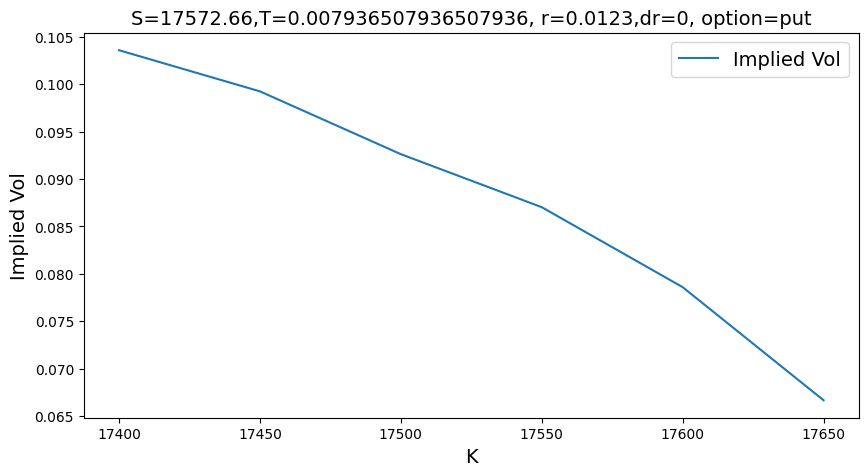

[0.10357410378762859, 0.09923986171671136, 0.0926209024077845, 0.08703408701299552, 0.07860756537747572, 0.0666916637744648]


In [35]:
impvol_list_put = []
for i in range(len(K)):
    impvol = newton_method(S, K[i], T, r, dr, p[i], "put")
    impvol_list_put.append(impvol)
    
plt.figure(figsize=(10,5))
plt.plot(K, impvol_list_put, label='Implied Vol')
plt.title(f'S={S},T={T}, r={r},dr={dr}, option={"put"}', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Implied Vol', fontsize=14)
plt.legend(fontsize=14)
plt.show()

print(impvol_list_put)

18
20
20
21
21
21


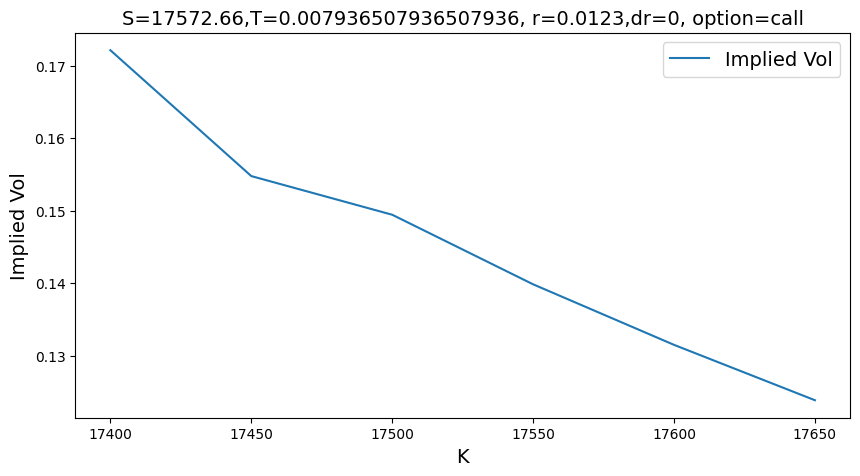

[0.17213286209106443, 0.1547664442062378, 0.14943406772613527, 0.13983571386337285, 0.13148282575607306, 0.12384315633773804]


In [36]:
impvol_list_call = []
for i in range(len(K)):
    impvol = bisection(S, K[i], T, r, dr, c[i], "call")
    impvol_list_call.append(impvol)
    
plt.figure(figsize=(10,5))
plt.plot(K, impvol_list_call, label='Implied Vol')
plt.title(f'S={S},T={T}, r={r},dr={dr}, option={"call"}', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Implied Vol', fontsize=14)
plt.legend(fontsize=14)
plt.show()

print(impvol_list_call)

19
19
21
21
20
20


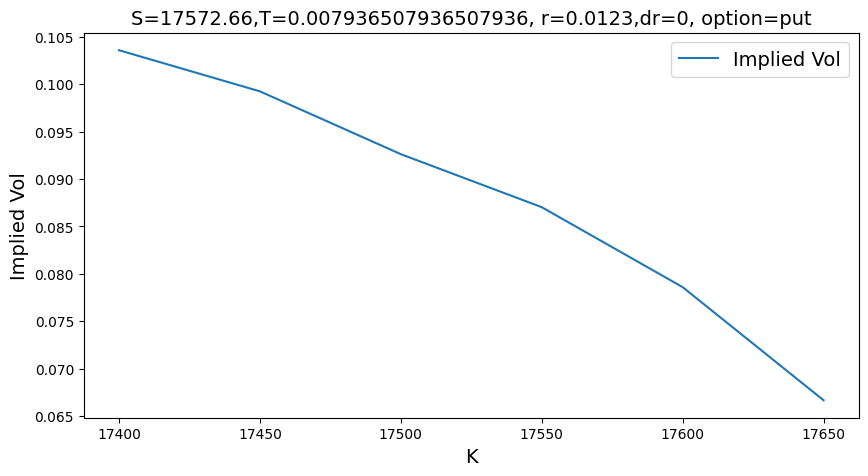

[0.10357395362854005, 0.09923977851867677, 0.09262078905105589, 0.0870339093208313, 0.07860748958587646, 0.06669155597686768]


In [37]:
impvol_list_put = []
for i in range(len(K)):
    impvol = bisection(S, K[i], T, r, dr, p[i], "put")
    impvol_list_put.append(impvol)
    
plt.figure(figsize=(10,5))
plt.plot(K, impvol_list_put, label='Implied Vol')
plt.title(f'S={S},T={T}, r={r},dr={dr}, option={"put"}', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Implied Vol', fontsize=14)
plt.legend(fontsize=14)
plt.show()

print(impvol_list_put)

## Combiantorics of Binomial Tree

In [38]:
# Test parameters
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to maturity
r = 0.05 # Risk-free rate
dr = 0.02   # Dividend rate
sigma = 0.1 # Volatility
N = 100   # Number of steps
option = "call"

# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((5.461330760665701, 0.0030221939086914062),
 (5.4613307606657155, 0.01196599006652832))

In [39]:
option = "put"
# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((2.564405880061789, 0.004293203353881836),
 (2.5644058800617944, 0.015269279479980469))

In [40]:
N = 500
option = "call"
# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((5.469342982181702, 0.011543035507202148),
 (5.469342982182705, 0.1262521743774414))

In [41]:
option = "put"
# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((2.5724181015747463, 0.01218104362487793),
 (2.5724181015752126, 0.12306475639343262))

In [42]:
N = 1000
option = "call"
# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((5.470345654437473, 0.022166013717651367),
 (5.470345654435003, 0.3881077766418457))

In [43]:
option = "put"
# Measure and compare the efficiency of both functions
start_time_func = time()
price_func = bin_comb(S, K, T, r, dr, sigma, N, option)
end_time_func = time()

start_time_binomial = time()
price_binomial = binomial_tree(S, K, T, r, dr, sigma, N, option)
end_time_binomial = time()

time_func = end_time_func - start_time_func
time_binomial = end_time_binomial - start_time_binomial

(price_func, time_func), (price_binomial, time_binomial)

((2.5734207738368045, 0.005301952362060547),
 (2.5734207738356125, 0.3558318614959717))